In [1]:
import ast
import pandas as pd
import sys
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import numpy as np


# Add project src directory to Python path
sys.path.append("/home/karthik/Desktop/drowsiness_detection_project/llm_eval/src")

# Now import utils directly (no 'src.' prefix)
from notebooks.utils import *

In [2]:
path = r"/home/karthik/Desktop/drowsiness_detection_project/drowsiness_data/balu_dataset.csv"

In [3]:
df = pd.read_csv(path)

In [4]:
# Selecting relevant columns
columns = ['window_id', 'metric_PERCLOS', 'metric_BlinkRate',
       'metric_YawnRate', 'metric_Entropy', 'metric_SteeringRate',
       'metric_SDLP', 'raw_ear', 'raw_mar', 'raw_steering', 'raw_lane',
       'karthik_drowsiness_level', 'karthik_notes',
       'karthik_submission_type', 'Vanchha_drowsiness_level',
       'Vanchha_notes', 'Vanchha_submission_type',
      ]

In [5]:
df = pd.read_csv(path)

In [6]:
df["raw_ear"].isnull().sum()

np.int64(0)

In [7]:
# converting the string representation of list to actual list
df["raw_ear"] = df["raw_ear"].apply(ast.literal_eval)
df["steering_angle"] = df["raw_steering"].apply(
    lambda x: [v * 70 for v in ast.literal_eval(x)]
)

In [8]:
# correcting metric_PERCLOS by chaninging min_consec_frames to 0
df["metric_PERCLOS"] = df["raw_ear"].apply(lambda x: calculate_perclos(np.array(x), ear_threshold=0.2, min_consec_frames=0))

In [9]:
df[['blink_duration_mean', 'blink_duration_std', 'blink_duration_max']] = df['raw_ear'].apply(
    lambda x: pd.Series(calculate_blink_stats_all(np.array(x), ear_threshold=0.2))
)

In [10]:
df["metric_SteeringRate"] = df["steering_angle"].apply(lambda x: steering_reversal_rate(
    steering_angle=np.array(x),
    gap_size = 3.0,
    lowpass_cutoff = 0.6,
    filter_order= 2,
))

In [11]:
df["metric_Entropy"] = df["steering_angle"].apply(lambda x: approx_entropy(np.array(x)))

In [12]:
df["label"] = df.apply(checking_conflict, axis=1)

In [13]:
# removed this row because he crashed in to the barriers
df = df[df["window_id"] != 84]

In [14]:
df = df.dropna(subset=["label"])

In [15]:
df['drowsiness_level'] = df['label'].map({'Low': 1, 'Moderate': 2, 'High': 3})

In [16]:
final_columns = [
    'window_id', 'metric_PERCLOS', 'metric_BlinkRate', 'blink_duration_mean', 'blink_duration_std', 'blink_duration_max',"metric_YawnRate",
    'metric_Entropy', 'metric_SteeringRate', 'metric_SDLP', "drowsiness_level",
]

In [17]:
df = df[final_columns]

In [18]:
df.iloc[60, df.columns.get_loc("drowsiness_level")] = 3

In [19]:
df.iloc[60]

window_id              70.000000
metric_PERCLOS          6.662902
metric_BlinkRate       35.559422
blink_duration_mean     0.114221
blink_duration_std      0.194214
blink_duration_max      1.118012
metric_YawnRate         0.000000
metric_Entropy          0.043648
metric_SteeringRate     1.000000
metric_SDLP             0.404925
drowsiness_level        3.000000
Name: 70, dtype: float64

In [20]:
df.reset_index(inplace=True, drop=True)

In [21]:
def detect_inconsistent_labels_knn(df, features, label_col='drowsiness_level', k=5):
    X = StandardScaler().fit_transform(df[features])
    y = df[label_col].values

    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    _, indices = nbrs.kneighbors(X)

    inconsistencies = []
    for i, neigh_idx in enumerate(indices):
        neigh_labels = y[neigh_idx[1:]]  
        same_label_ratio = np.mean(neigh_labels == y[i])
        if same_label_ratio < 0.3:  
            inconsistencies.append(i)
    
    print(inconsistencies)

    return df.iloc[inconsistencies], df.drop(df.index[inconsistencies])

In [22]:
def final_conflicts(df, features):
    results = {}  # store inconsistent indices for each k
    for k in [2, 3, 4, 5]:
        suspect_df, _ = detect_inconsistent_labels_knn(df, features, k=k)
        results[k] = set(suspect_df.index)

    # Combine votes
    all_suspects = pd.Series(0, index=df.index)
    for k, idx_set in results.items():
        all_suspects.loc[list(idx_set)] += 1

    final_suspects = df.loc[all_suspects >= 3]
    clean_df = df.loc[all_suspects < 3]

    return final_suspects, clean_df

In [23]:
df.columns

Index(['window_id', 'metric_PERCLOS', 'metric_BlinkRate',
       'blink_duration_mean', 'blink_duration_std', 'blink_duration_max',
       'metric_YawnRate', 'metric_Entropy', 'metric_SteeringRate',
       'metric_SDLP', 'drowsiness_level'],
      dtype='object')

In [24]:
features = ['window_id', 'metric_PERCLOS', 'metric_BlinkRate',
       'blink_duration_mean', 'blink_duration_std', 'blink_duration_max',
       'metric_YawnRate', 'metric_Entropy', 'metric_SteeringRate',
       'metric_SDLP']

In [25]:
df_cleaned, cleaned_df = final_conflicts(df, features)

[59, 60, 62, 63, 66, 71, 72, 73, 75, 77, 78, 79, 80, 81, 82, 83, 90, 91]
[59, 62, 63, 71, 77, 78, 79, 80, 83, 91]
[59, 63, 71, 77, 78, 79, 80, 83, 91]
[59, 60, 61, 62, 63, 71, 75, 77, 78, 79, 80, 81, 83, 91]


In [26]:
df_cleaned

,window_id,metric_PERCLOS,metric_BlinkRate,blink_duration_mean,blink_duration_std,blink_duration_max,metric_YawnRate,metric_Entropy,metric_SteeringRate,metric_SDLP,drowsiness_level
59,69,0.507614,6.084283,0.050761,0.037835,0.135364,0.0,0.057256,0.0,0.788786,1
62,72,0.620068,7.097422,0.053149,0.024637,0.101466,0.0,0.072503,4.0,0.560361,1
63,73,1.183099,13.165596,0.054605,0.031203,0.135211,0.0,0.083707,3.0,0.446425,1
71,82,0.451467,6.094465,0.045147,0.015962,0.067720,0.0,0.051313,3.0,0.551251,2
77,89,0.786075,6.053407,0.078608,0.060473,0.202134,0.0,0.064279,3.0,0.395780,3
78,90,0.280426,4.031279,0.042064,0.014571,0.067302,0.0,0.087843,3.0,0.376075,3
79,91,0.056085,1.008309,0.033651,0.000000,0.033651,0.0,0.043172,3.0,0.571066,3
80,92,0.451977,6.090027,0.045198,0.015980,0.067797,0.0,0.075327,2.0,0.586018,1
83,95,1.069820,13.164107,0.049376,0.025196,0.101351,0.0,0.054440,3.0,0.411795,3
91,104,2.137233,16.173928,0.080146,0.067360,0.269966,0.0,0.100154,1.0,0.559264,3


In [27]:
cleaned_df["drowsiness_level"].value_counts()

drowsiness_level
1    61
2    22
3     1
Name: count, dtype: int64

In [28]:
features = ['window_id', 'metric_PERCLOS', 'metric_BlinkRate',
       'blink_duration_mean', 'blink_duration_std', 'blink_duration_max',
       'metric_YawnRate', 'metric_Entropy', 'metric_SteeringRate',
       'metric_SDLP']
x = cleaned_df.loc[:, features].values
x = StandardScaler().fit_transform(x)


In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)

In [30]:
y = cleaned_df["drowsiness_level"]

In [31]:
y.value_counts()

drowsiness_level
1    61
2    22
3     1
Name: count, dtype: int64

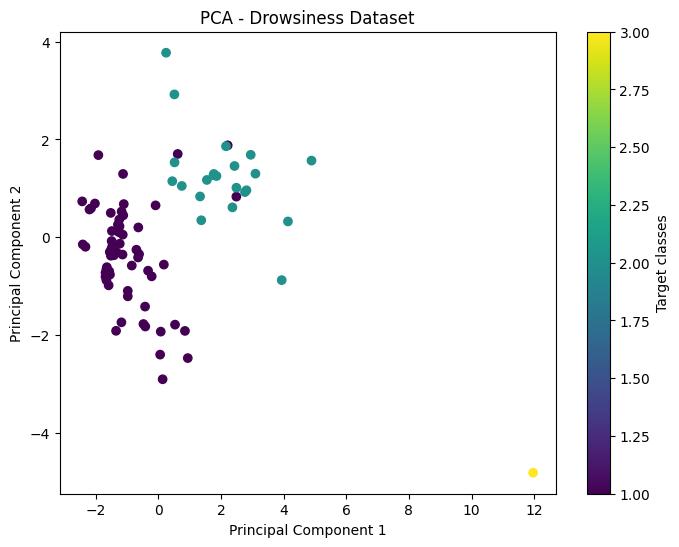

In [32]:
plt.figure(figsize=(8,6))
plt.scatter(principal_components[:,0], principal_components[:,1], c=y, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - Drowsiness Dataset')
plt.colorbar(label='Target classes')
plt.show()

In [33]:
cleaned_df["drowsiness_level"].value_counts()

drowsiness_level
1    61
2    22
3     1
Name: count, dtype: int64

In [34]:
pca.explained_variance_ratio_

array([0.51237137, 0.19323557])

In [35]:
from scipy.stats import mode

from sklearn.cluster import KMeans

# Assuming X_pca = your PCA features, y = current labels
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(principal_components)


y = np.array(y) 
new_labels = y.copy()

for clust in np.unique(cluster_labels):
    indices = np.where(cluster_labels == clust)[0]
    labels_in_cluster = y[indices]
    majority_label = mode(labels_in_cluster, keepdims=True).mode[0]

    # only change mismatched points (avoid overwriting minority clusters)
    for idx in indices:
        if y[idx] != majority_label and y[idx] != 3:
            new_labels[idx] = majority_label




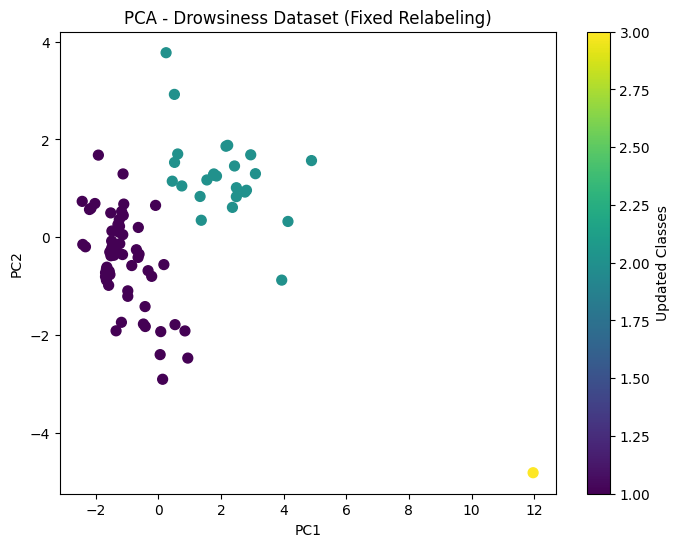

In [36]:
plt.figure(figsize=(8,6))
plt.scatter(principal_components[:,0], principal_components[:,1], c=new_labels, cmap='viridis', s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA - Drowsiness Dataset (Fixed Relabeling)')
plt.colorbar(label='Updated Classes')
plt.show()


In [37]:
cleaned_df["drowsiness_level"] = new_labels

/tmp/ipykernel_3047871/1161312063.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df["drowsiness_level"] = new_labels


In [38]:
cleaned_df["drowsiness_level"].value_counts()

drowsiness_level
1    58
2    25
3     1
Name: count, dtype: int64

In [39]:
cleaned_df.to_csv("/home/karthik/Desktop/drowsiness_detection_project/drowsiness_data/balu_processed_data.csv")

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, cleaned_df["drowsiness_level"], test_size=0.2, random_state=42)


In [41]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
print("Accuracy:", model.score(X_test, y_test))

Accuracy: 0.9411764705882353


In [42]:
cleaned_df

,window_id,metric_PERCLOS,metric_BlinkRate,blink_duration_mean,blink_duration_std,blink_duration_max,metric_YawnRate,metric_Entropy,metric_SteeringRate,metric_SDLP,drowsiness_level
0,8,0.673401,8.078447,0.050505,0.023808,0.101010,0.0,0.111337,6.0,0.432780,2
1,9,0.560224,5.033525,0.067227,0.021259,0.100840,0.0,0.051466,3.0,0.368338,1
2,10,0.448934,5.047730,0.053872,0.016495,0.067340,0.0,0.056554,1.0,0.419363,1
3,11,0.842697,11.107796,0.045965,0.016215,0.067416,0.0,0.025270,1.0,0.157106,1
4,12,0.673023,5.038488,0.080763,0.034318,0.134605,0.0,0.028980,2.0,0.289306,1
...,...,...,...,...,...,...,...,...,...,...,...
88,100,2.718007,27.543880,0.060400,0.050081,0.271801,0.0,0.060234,2.0,0.794328,2
89,102,2.985915,25.322433,0.071662,0.051770,0.270423,0.0,0.056547,0.0,0.259543,2
90,103,3.038829,21.292691,0.086824,0.046098,0.202589,0.0,0.048771,3.0,0.375799,2
92,106,1.802817,20.255921,0.054085,0.032773,0.169014,0.0,0.084091,1.0,0.266961,2


In [44]:
cleaned_df[1:].to_csv("/home/karthik/Desktop/drowsiness_detection_project/drowsiness_data/balu_processed_data.csv")